# Comparing wasm exported Datasets with Rust natives

In this notebook, we compare the performances of wasm exported and rust natives datasets.

The studied datasets are Sophia FastDataset, Sophia LightDataset, our own FullDataset (a data structure that uses HashMap of every possible key parts to the whole dataset) and our own TreeDataset (a data structure that can index every possible quad order, and store them using trees)

## Loading data

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [30]:
datasets = [
    ("Fast", ["sophia", "sophia_A", "sophia_js", "sophia_js_A"]),
    ("Light", ["sophia_lg", "sophia_lg_A", "sophia_js_lg", "sophia_js_A_lg"]),
    ("Tree", ["sophia_tree", "sophia_tree_A", "sophia_js_tree", "sophia_js_A_tree"]),
    ("Full", ["sophia_full", "sophia_full_A", "sophia_js_full", "sophia_js_A_full"]),
    ("Array", ["sophia_array", "sophia_array", "sophia_js_array", "sophia_js_array"]),
    ("Graphy", [None, None, "sophia_js_graphy", "sophia_js_graphy"])
]

prefixes = "witharray/fillforeach_"
queries = ["query", "query3", "query2", "query4"]
extension = ".csv"

def query_test(query):
    if query == "query" or query == "query1":
        return "<POG>"
    elif query == "query2":
        return "<SG>"
    elif query == "query3":
        return "<PO>"
    else:
        return "<S>"

## Compute average

In [31]:
data = {}

for query in queries:
    for dataset_kind in datasets:
        name = dataset_kind[0]
        list_of_files = dataset_kind[1]

        def read_file(filename):
            d = {}
            
            if filename is None:
                return d
            
            filename = prefixes + query + "-" + filename + extension

            with open(filename, 'r') as file:
                reader = csv.reader(file)

                is_first = True
                for row in reader:
                    if is_first:
                        is_first = False
                    else:
                        nb_of_quads = int(row[1])
                        if nb_of_quads not in d:
                            d[nb_of_quads] = []

                        #total_time = float(row[7]) + float(row[8])
                        total_time = float(row[7]) + float(row[8])
                        d[nb_of_quads].append(total_time)
        
            return d

        data[("Rust", name, query, "Self")] = read_file(list_of_files[0])
        data[("Rust", name, query, "Array")] = read_file(list_of_files[1])
        data[("Wasm", name, query, "Self")] = read_file(list_of_files[2])
        data[("Wasm", name, query, "Array")] = read_file(list_of_files[3])

def avg(l):
    i = 0
    for x in l:
        i += x
    return i / len(l)

for key in data:
    for ds in data[key]:
        data[key][ds] = avg(data[key][ds])

In [32]:
import pprint as pp

for x in data:
    print(x)
    pp.pprint(data[x], indent=2)
    break

('Rust', 'Fast', 'query', 'Self')
{ 10000: 0.0014557234999999999,
  20000: 0.0031370469999999996,
  40000: 0.0065083087500000004,
  80000: 0.015082167,
  100000: 0.0169386115,
  1000000: 0.2725741105}


In [33]:
def draw_plot(queries, graph_name, intermediates):
    plt.rcParams["figure.figsize"]=20,10
    
    def dd(query_name, p):
        for intermediate in intermediates:
            for target in ['Rust', 'Wasm']:
            #for target in ['Wasm']:
                x = []
                y = []

                for entry in data:
                    if entry[0] == target and entry[1] == graph_name and entry[2] == query_name and entry[3] == intermediate:
                        for size in data[entry]:
                            x.append(size)
                            y.append(data[entry][size])

                qname = query_name
                if qname == "query":
                    qname = "query1"

                p.loglog(x, y, label=target + " " + intermediate)
        
        p.legend()
    
    fig, axs = plt.subplots(2, 2, sharex='col', sharey='row')
    (p1, p2), (p3, p4) = axs
    
    dd(queries[0], p1)
    dd(queries[1], p2)
    dd(queries[2], p3)
    dd(queries[3], p4)
    print("Comparing " + graph_name + " Dataset on POG / PO then SG / S")
    
    axes = plt.gca()
    axes.set_ylim(10**-7, 1)
    plt.show()

## Plot drawing

We draw a plot for every dataset and query to compare the plot shape

- x = number of quads in the dataset
- y = time to answer in second

When using the `match` function a new dataset is created. Self means that the same dataset structure is used to wrap the new dataset, Array means that the created dataset is a simple array.

Comparing Fast Dataset on POG / PO then SG / S


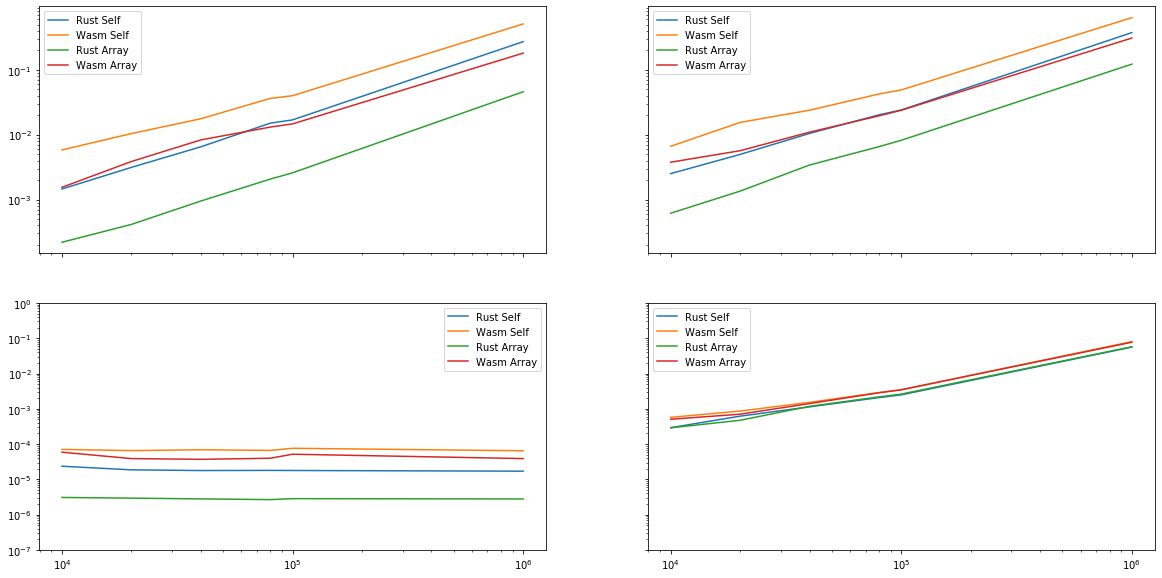

Comparing Light Dataset on POG / PO then SG / S


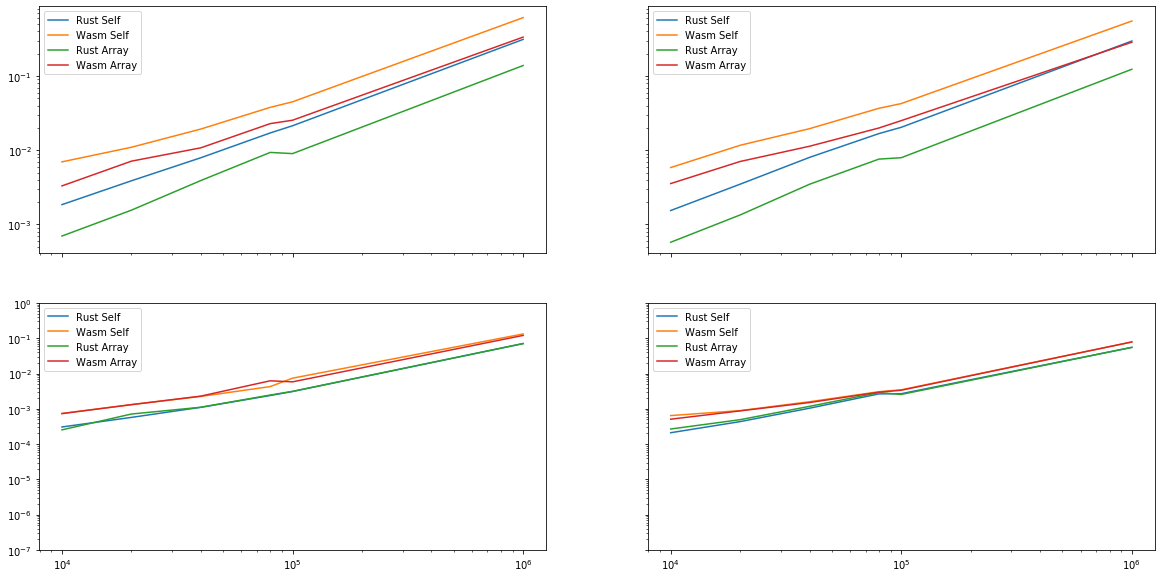

Comparing Tree Dataset on POG / PO then SG / S


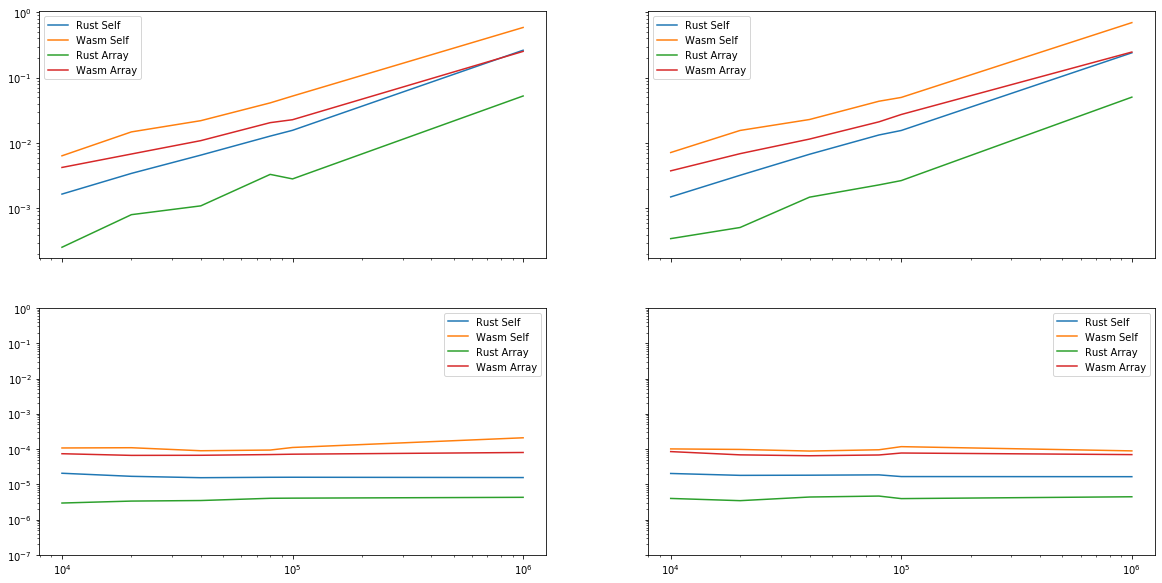

Comparing Full Dataset on POG / PO then SG / S


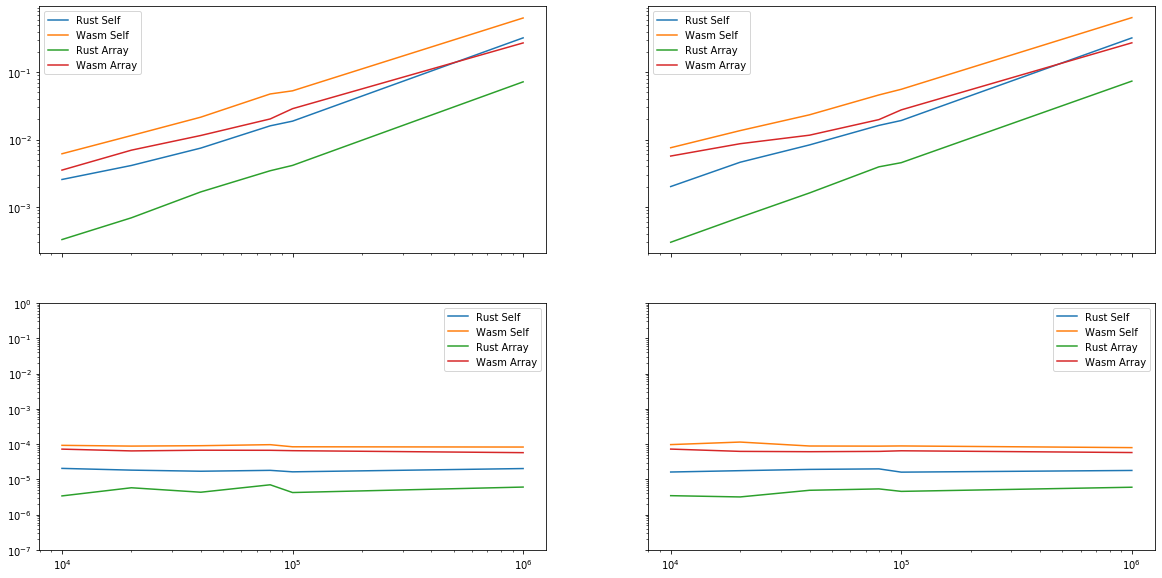

Comparing Array Dataset on POG / PO then SG / S


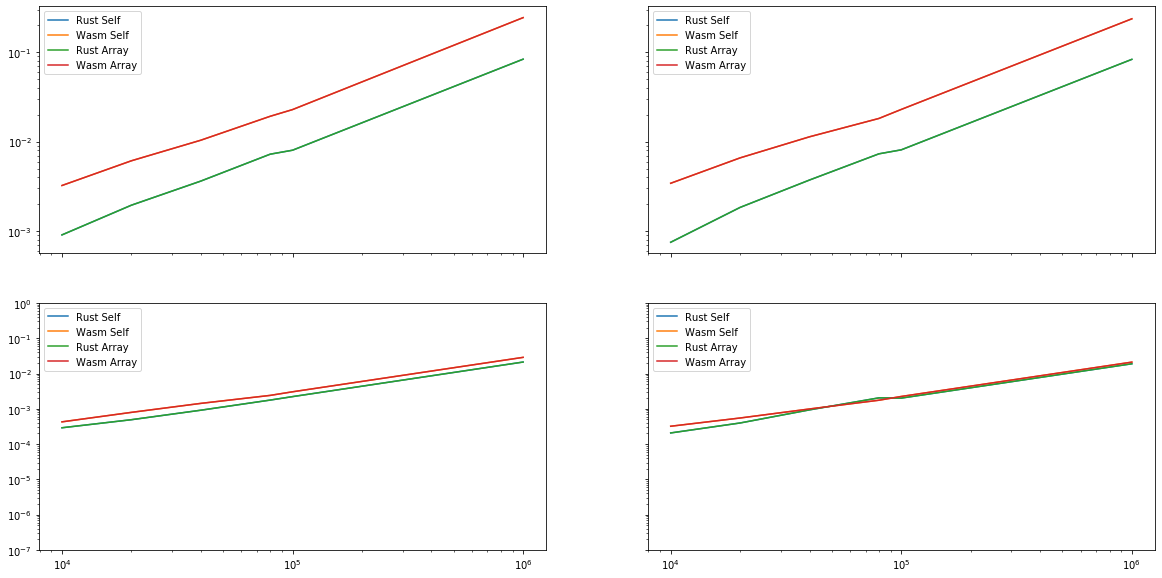

Comparing Graphy Dataset on POG / PO then SG / S


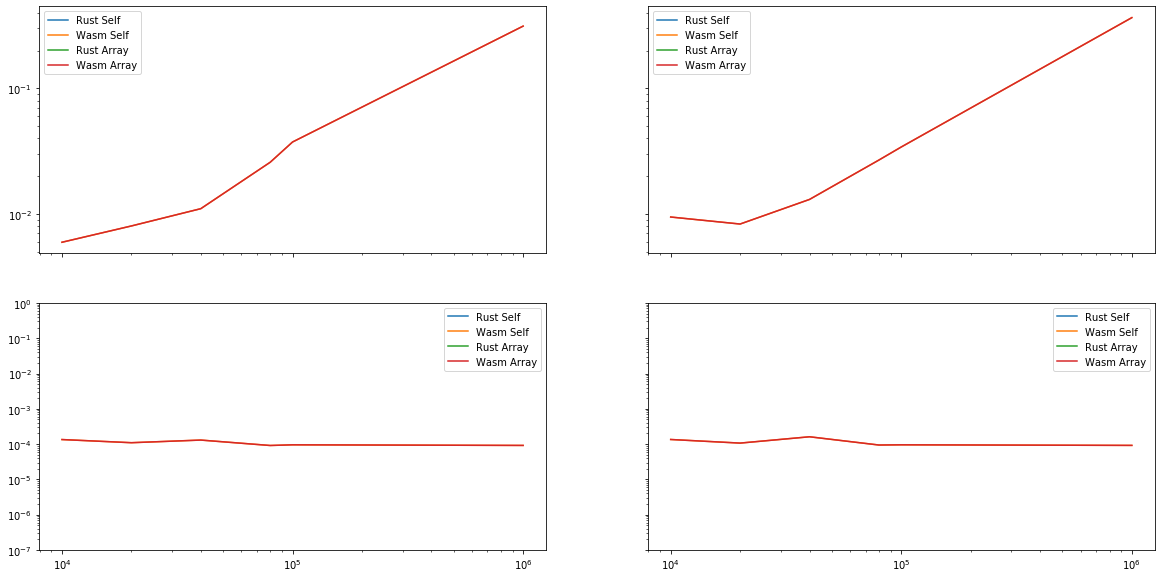

In [34]:
for dataset_type in datasets:
    draw_plot(["query", "query3", "query2", "query4"], dataset_type[0], ["Self", "Array"])

For the same query and datastructure, native Rust and Wasm exported datasets have the same plot, ie the same complexity.

## Comparing different datasets

A new draw plot function

In [35]:
def draw_plot(queries, datasets, targets, intermediates):
    def make_title(q, d, t, i):
        if d == "Graphy":
            return "Graphy"
        
        zz = ""
        
        if len(queries) != 1:
            zz += q + " "        
        if len(datasets) != 1:
            zz += d + " "        
        if len(targets) != 1:
            zz += t + " "        
        if len(intermediates) != 1:
            zz += i + " "
        return zz
    
    graphy_ok = False
    
    for query in queries:
        for target in targets:
            for dataset in datasets:
                for intermediate in intermediates:
                    if dataset == "Graphy" and graphy_ok:
                        continue
                    
                    x = []
                    y = []

                    for entry in data:
                        if entry[2] == query and entry[1] == dataset and target == entry[0] and intermediate == entry[3]:
                            for size in data[entry]:
                                x.append(size)
                                y.append(data[entry][size])
                    
                    if len(x) > 0:
                        if dataset == "Graphy":
                            graphy_ok = True
                        plt.loglog(x, y, label=make_title(query, dataset, target, intermediate))
        
    # plt.title("Comparing " + graph_name + " Dataset on " + qname)
    axes = plt.gca()
    axes.set_ylim(10**-7, 1)
    plt.legend()
    
    plt.show()
    
plt.rcParams["figure.figsize"]=10,5

## Exploring queries

### Query 1 : POG

Every dataset behave the same.

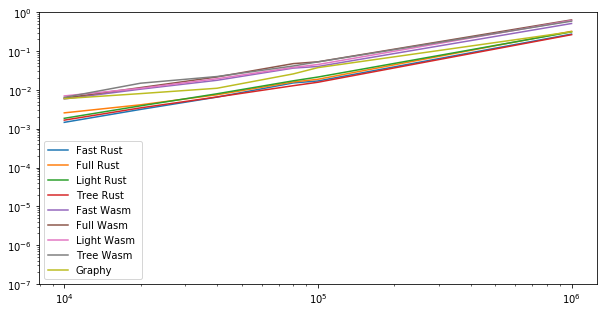

In [36]:
draw_plot(["query"], ["Fast", "Full", "Light", "Tree", "Graphy"], ["Rust", "Wasm"], ["Self"])

### Query 4 : S only

Fast and Light are slow because they don't have any efficient index : they have to loop of the whole dataset.

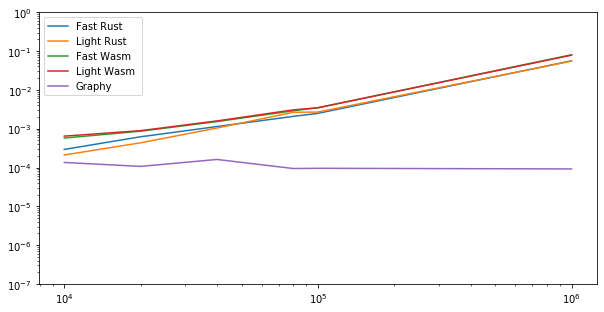

In [37]:
draw_plot(["query4"], ["Fast", "Light", "Graphy"], ["Rust", "Wasm"], ["Self"])

After the first execution, Tree and Full have the right index and can find in constant time the result

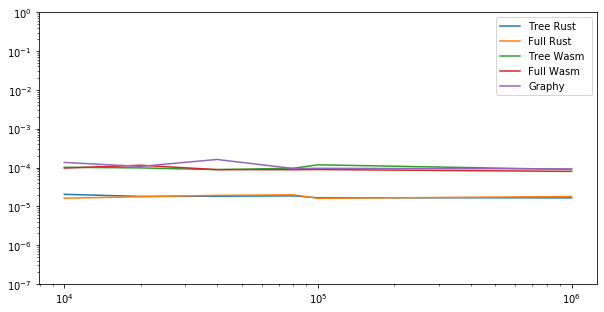

In [38]:
draw_plot(["query4"], ["Tree", "Full", "Graphy"], ["Rust", "Wasm"], ["Self"])

## Query 2 (SG)

--- query 2 on datasets ---
Light : an inneficient solution


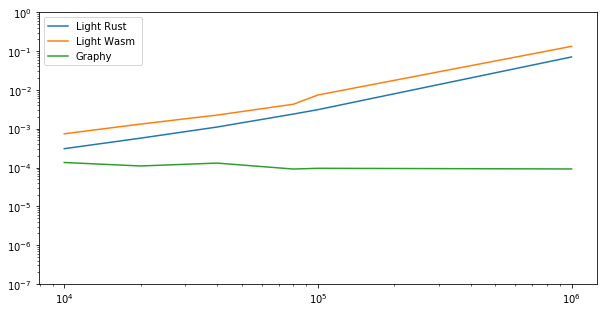

Fast, Tree and Full :


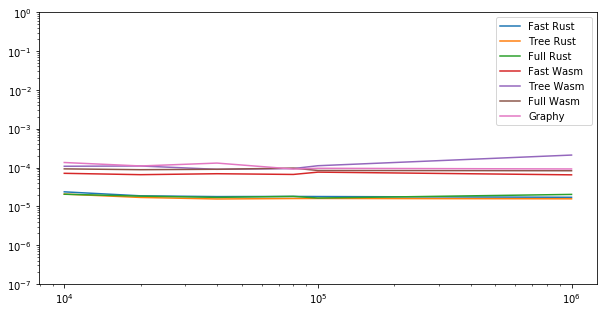

Rust (bottom part of the previous graph)


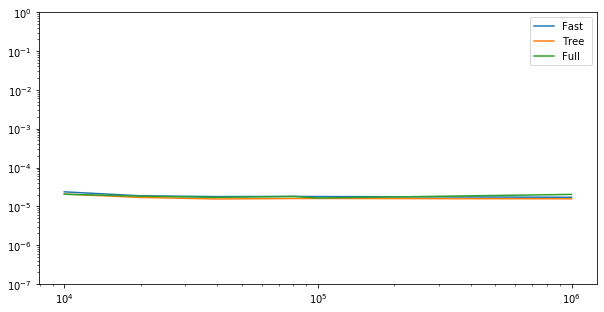

Wasm (top part of the previous of the previous graph)


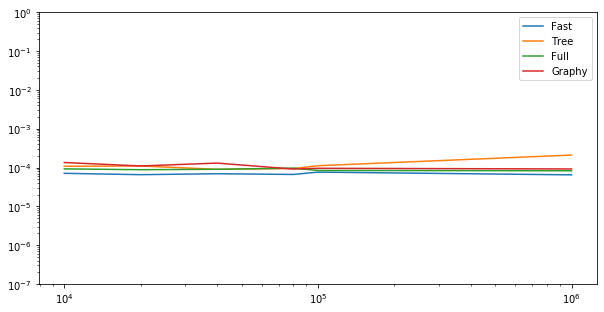

In [39]:
print("--- query 2 on datasets ---")
print("Light : an inneficient solution")
draw_plot(["query2"], ["Light", "Graphy"], ["Rust", "Wasm"], ["Self"])
print("Fast, Tree and Full :")
draw_plot(["query2"], ["Fast", "Tree", "Full", "Graphy"], ["Rust", "Wasm"], ["Self"])
print("Rust (bottom part of the previous graph)")
draw_plot(["query2"], ["Fast", "Tree", "Full", "Graphy"], ["Rust"], ["Self"])
print("Wasm (top part of the previous of the previous graph)")
draw_plot(["query2"], ["Fast", "Tree", "Full", "Graphy"], ["Wasm"], ["Self"])

### Fast vs Tree

Blue = Fast ; Orange = Tree
<POG> in Rust


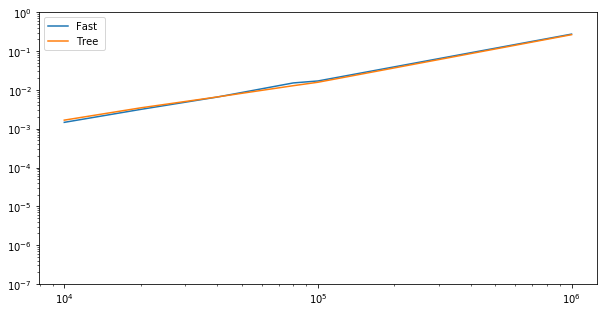

<POG> in Wasm


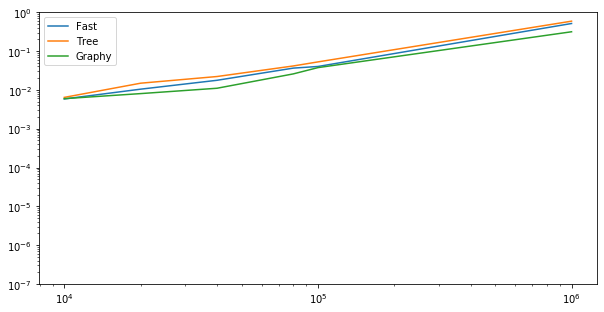

<PO> in Rust


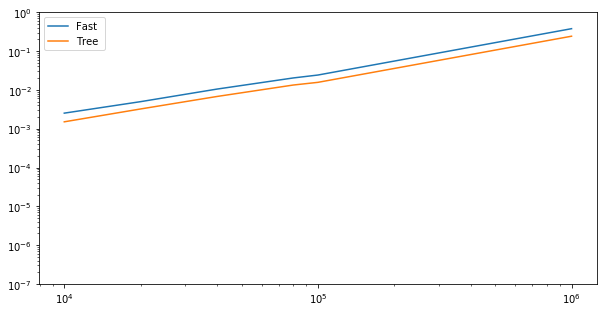

<PO> in Wasm


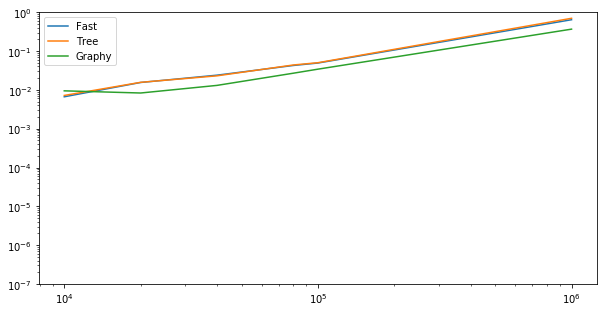

<SG> in Rust


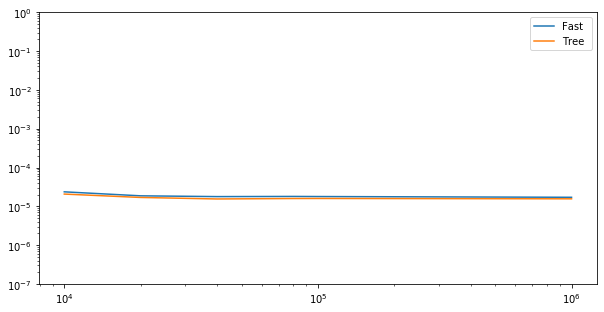

<SG> in Wasm


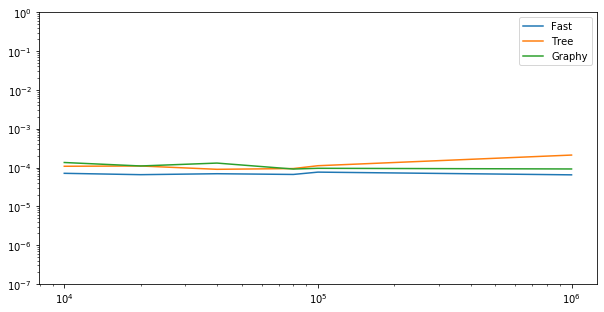

<S> in Rust


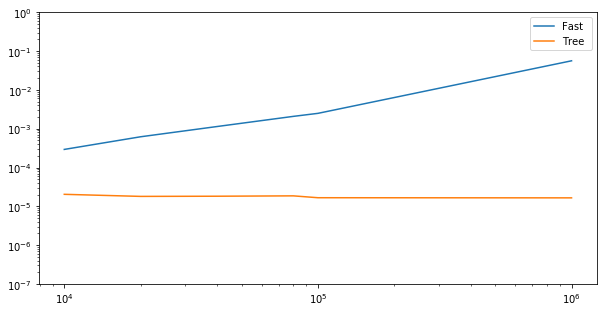

<S> in Wasm


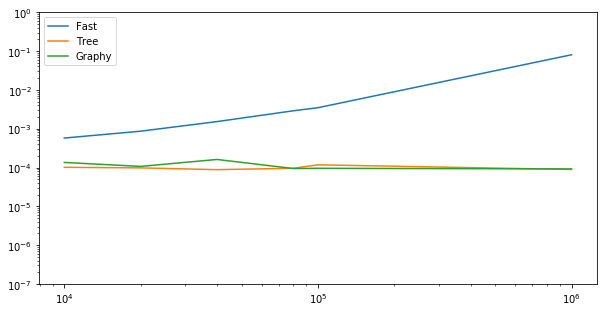

In [40]:
print("Blue = Fast ; Orange = Tree")

for query in queries:
    for target in ["Rust", "Wasm"]:
        print(query_test(query) + " in " + target)
        draw_plot([query], ["Fast", "Tree", "Graphy"], [target], ["Self"])

## Array, Graphy and Trees

<POG> in Wasm


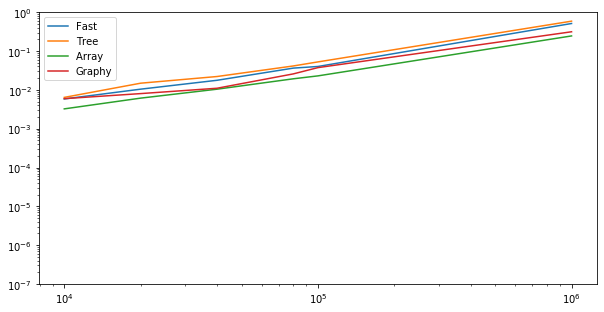

<PO> in Wasm


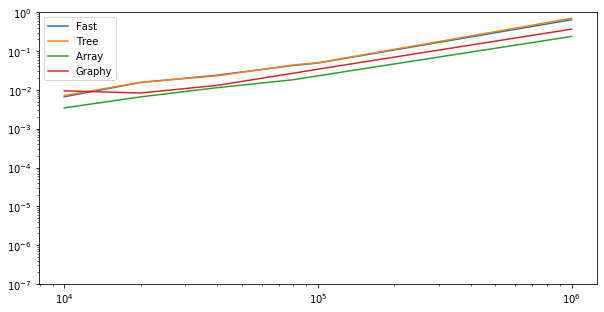

<SG> in Wasm


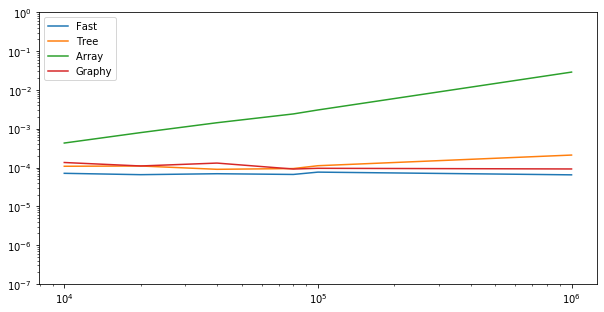

<S> in Wasm


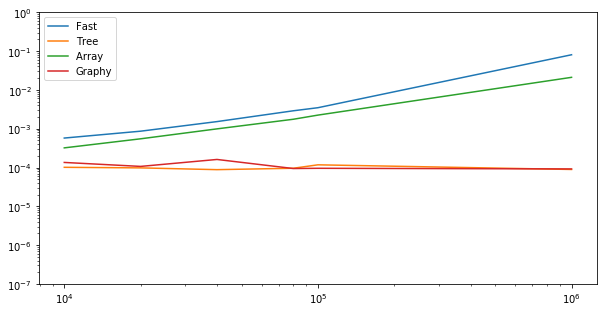

In [41]:
for query in queries:
    for target in ["Wasm"]:
        print(query_test(query) + " in " + target)
        draw_plot([query], ["Fast", "Tree", "Array", "Graphy"], [target], ["Self"])

<POG> in Rust


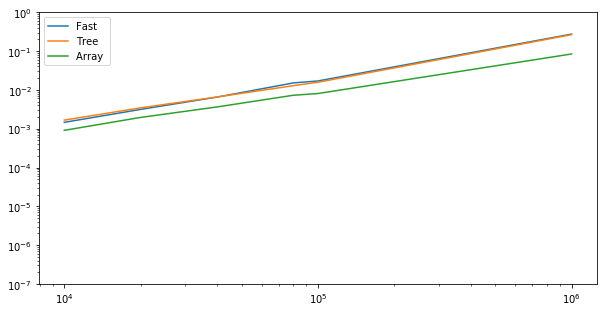

<PO> in Rust


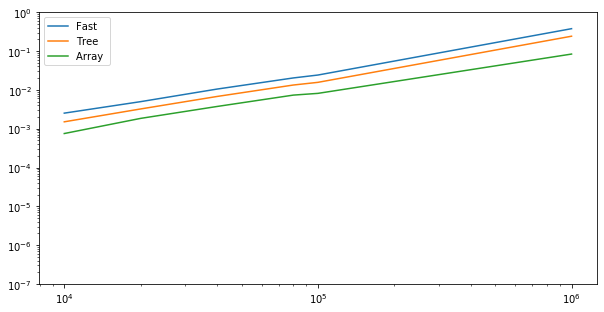

<SG> in Rust


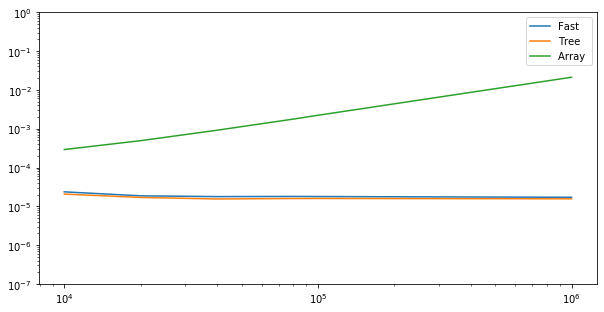

<S> in Rust


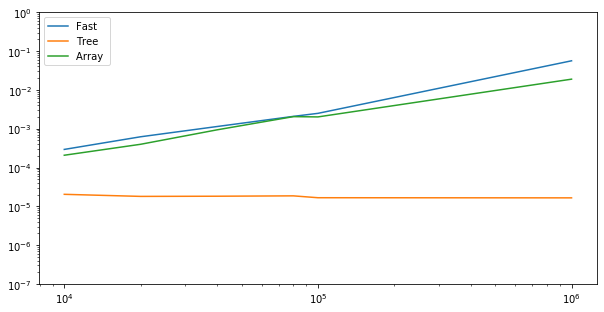

In [42]:
for query in queries:
    for target in ["Rust"]:
        print(query_test(query) + " in " + target)
        draw_plot([query], ["Fast", "Tree", "Array"], [target], ["Self"])

<POG> in Rust


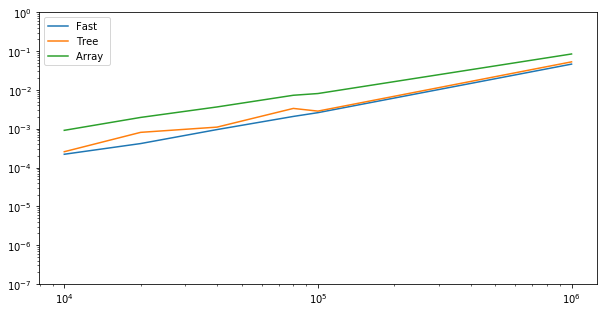

<PO> in Rust


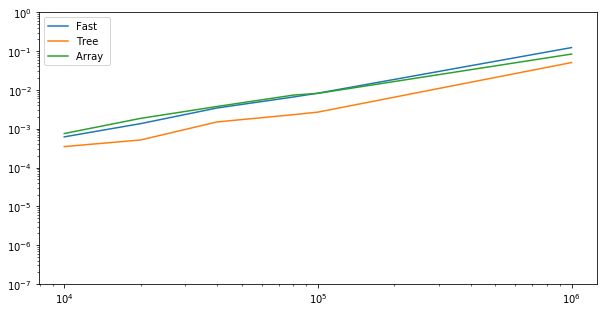

<SG> in Rust


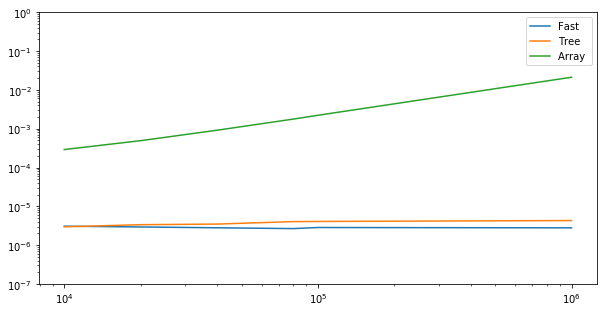

<S> in Rust


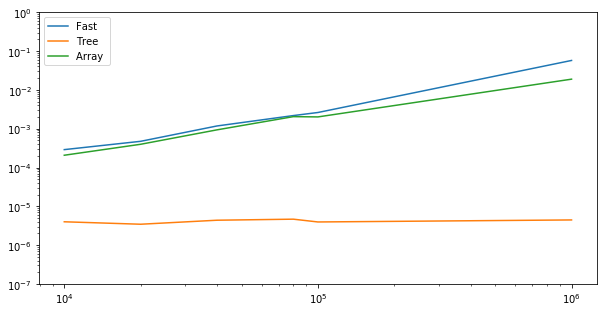

In [43]:
for query in queries:
    for target in ["Rust"]:
        print(query_test(query) + " in " + target)
        draw_plot([query], ["Fast", "Tree", "Array"], [target], ["Array"])

<POG> in Wasm


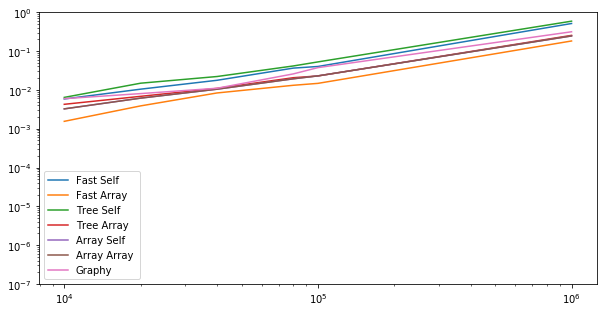

<PO> in Wasm


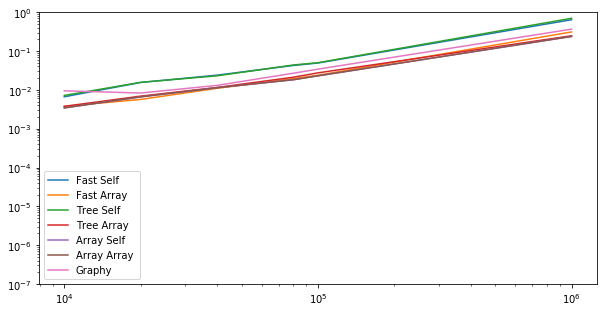

<SG> in Wasm


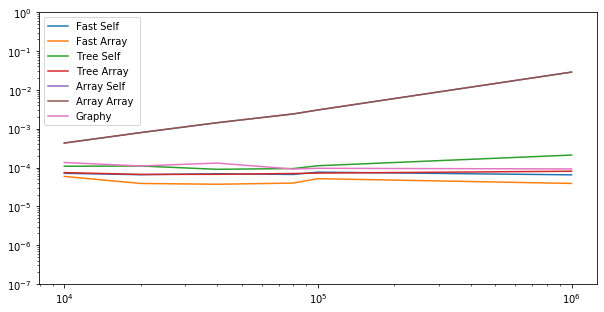

<S> in Wasm


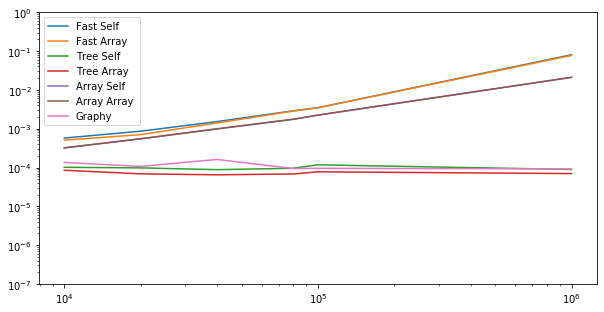

In [44]:
for query in queries:
    for target in ["Wasm"]:
        print(query_test(query) + " in " + target)
        draw_plot([query], ["Fast", "Tree", "Array", "Graphy"], [target], ["Self", "Array"])

<POG> benchmark in JS


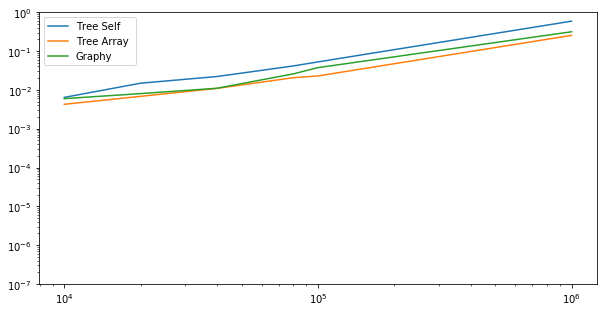

<PO> benchmark in JS


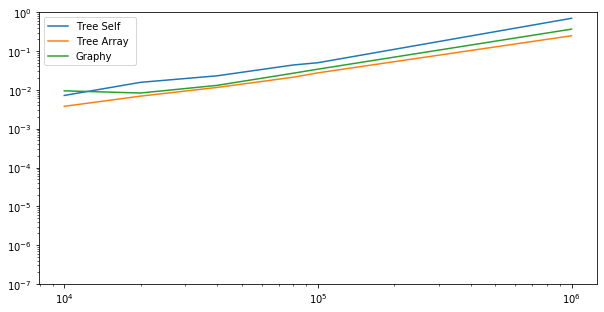

<SG> benchmark in JS


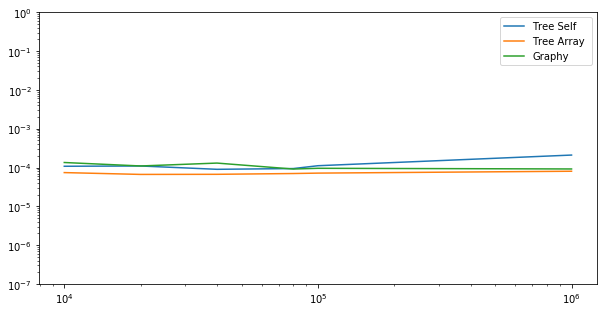

<S> benchmark in JS


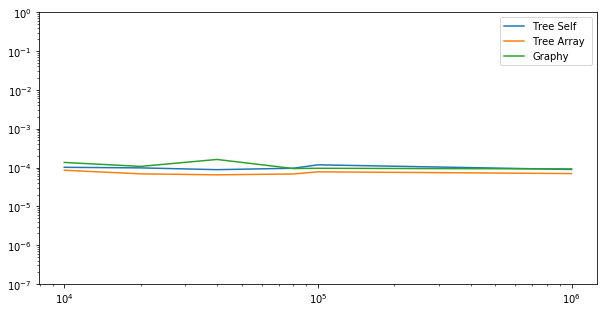

In [45]:
for q in queries:
    print(query_test(q) + " benchmark in JS")
    draw_plot([q], ["Tree", "Graphy"], ["Wasm"], ["Self", "Array"])

<POG> benchmark


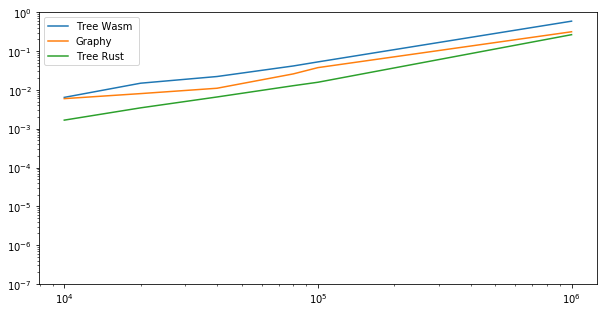

<PO> benchmark


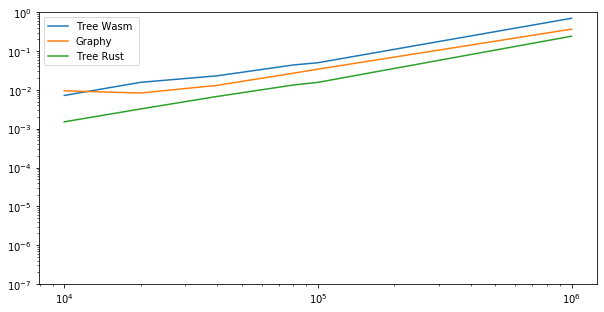

<SG> benchmark


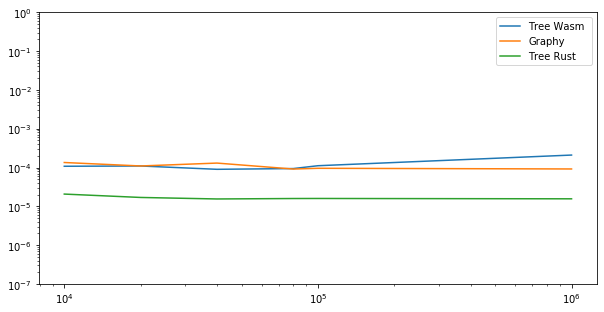

<S> benchmark


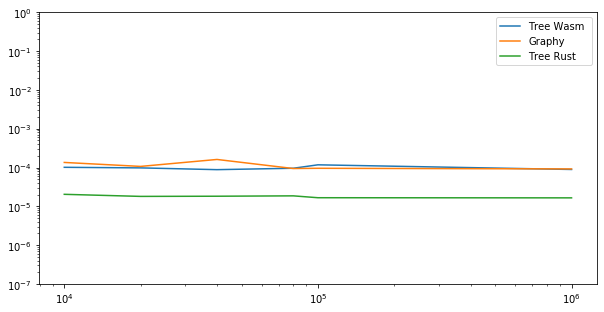

In [49]:
for q in queries:
    print(query_test(q) + " benchmark")
    draw_plot([q], ["Tree", "Graphy"], ["Wasm", "Rust"], ["Self"])

<POG> benchmark


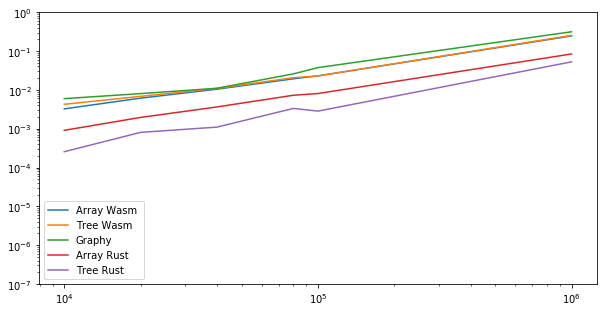

<PO> benchmark


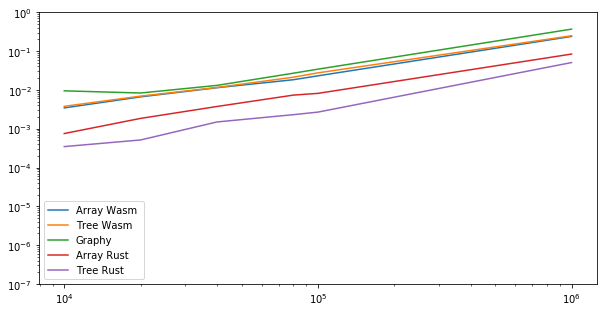

<SG> benchmark


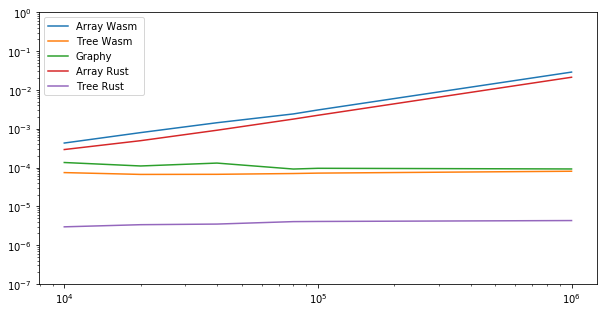

<S> benchmark


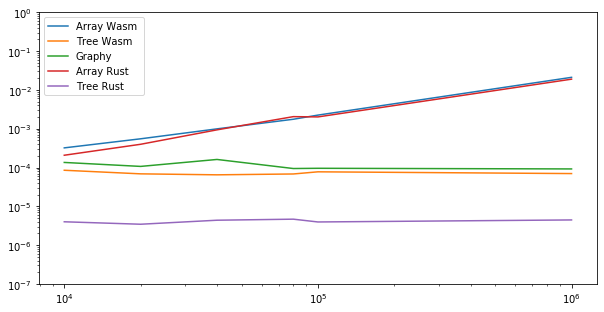

In [48]:
for q in queries:
    print(query_test(q) + " benchmark")
    draw_plot([q], ["Array", "Tree", "Graphy"], ["Wasm", "Rust"], ["Array"])